# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet


#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

#### Import the libs

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Loading the data from a stata file

In [2]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [3]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


### Dataset with résumés that received callbacks

In [4]:
data_calls = data[['id','race','call', 'education', 'yearsexp']].loc[data['call']==1]
data_calls.head()

,id,race,call,education,yearsexp
85,b,w,1.0,2,7
95,b,w,1.0,2,4
105,b,w,1.0,4,6
107,b,b,1.0,4,6
126,b,b,1.0,4,9


### Callbacks for white and black-sounding names  (a summary)

In [5]:
# total résumés in the dataset
n = data.shape[0]

# Callback / white/black-sounding name
total_call = data['id'].loc[data['call'] ==1.0].count()
call_w = data['id'].loc[(data['race'] =='w') & (data['call'] ==1.0)].count()
call_b = data['id'].loc[(data['race'] =='b') & (data['call'] ==1.0)].count()

# Summary
print("Total résumés = %d Curricula Vitae (CV)" % n)
print("Total callbacks = %d calls (%.2f%% all CV)" % (total_call,(100*(total_call/n))))
print("...")
print("...Callback for with white-sounding name = %d or %.2f%% from résumés with callbacks;" % (call_w, (100*(call_w/total_call))))
print("...Callback for black-sounding name = %d or %.2f%% from résumés with callbacks." % (call_b, (100*(call_b/total_call))))
print("...")
print("...Callback for white-sounding name is %.2f%% greater than for black-sounding names" % (100*((call_w - call_b)/call_w)))

Total résumés = 4870 Curricula Vitae (CV)
Total callbacks = 392 calls (8.05% all CV)
...
...Callback for with white-sounding name = 235 or 59.95% from résumés with callbacks;
...Callback for black-sounding name = 157 or 40.05% from résumés with callbacks.
...
...Callback for white-sounding name is 33.19% greater than for black-sounding names


#### A cross tabulation (*crosstab*) - a special case of Pivot Tabel - that summarize callbacks/race:

In [6]:
pd.crosstab(data_calls.race, data_calls.call, margins=True)

call,1.0,All
race,,
b,157,157
w,235,235
All,392,392


### Callbacks: a visual presentation

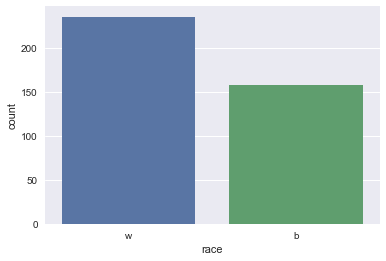

In [7]:
# A simple visual presentation with the total callbacks/race-sounding names 
sns.set(style="darkgrid")
ax = sns.countplot(x="race", data=data_calls[['race', 'call']])

### 1.What test is appropriate for this problem? Does CLT apply?

- We have a problem with variables that represents ***categorical values***: 'b', 'w'.<br>
- The question is about the the influence of race in the **rate** of callbacks: "...*whether race has a significant impact on the **rate** of callbacks for resumes..*"<br>
- The appropriate test is **two sample z-test** for **proportions**.

#### Does CLT apply?
Yes.

### 2.What are the null and alternate hypotheses?

#### The investigative question:  *The race - identify with a white or black-sounding names in resumes - has a significant impact on the rate of callbacks for resumes*?
#### So far we have the following proportion for callbacks:

In [8]:
print("+------------------------------|---------------------------+")
print("| Callbacks (total)            | %d calls (%.2f%% all CV)  |" % (total_call,(100*(total_call/n))))
print("|------------------------------|---------------------------|")
print("| Call for white-sounding name | %d or %.2f%% of callbacks|" % (call_w, (100*(call_w/total_call))))
print("| Call for black-sounding name | %d or %.2f%% of callbacks|" % (call_b, (100*(call_b/total_call))))
print("+------------------------------|---------------------------+")
print("")
print("Callback for white-sounding name is %.2f%% greater than for black-sounding names" % (100*((call_w - call_b)/call_w)))

+------------------------------|---------------------------+
| Callbacks (total)            | 392 calls (8.05% all CV)  |
|------------------------------|---------------------------|
| Call for white-sounding name | 235 or 59.95% of callbacks|
| Call for black-sounding name | 157 or 40.05% of callbacks|
+------------------------------|---------------------------+

Callback for white-sounding name is 33.19% greater than for black-sounding names


### Hypothesis:

#### 2.1 Null hypothesis: **H0 => "Race has NOT a significant impact on the rate of callbacks for résumés"**. In other words, the **rate** or **proportion** between callbacks for white and black-sounding names is the same: **50%**.

#### 2.2 - Alternative hypothesis: **Ha => "Race has a significant impact on the rate of callbacks for résumés"**. In other words, the **rate** or **proportion** between callbacks for white and black-sounding names is not the same: **not equal to 50%**.

### 3. Compute margin of error, confidence interval, and p-value

### The z-test formula for proportion:

![z-test-proportion](images/img_z-test-proportion.png)

### Where:

In [9]:
# Proportion for callback (white-sounding names)
p1 = call_w/total_call

# Proportion for callback (black-sounding names)
p2 = call_b/total_call

# Overall Proportion
p  = (call_w + call_b)/(2*total_call)

# Total callbacks (white-sounding names)
n1 = call_w

# Total callbacks (black-sounding names)
n2 = call_b

print("+----|-------|-----------------------------------------+")
print("| p1 | %.2f | %% of callbacks for white-sounding names |" % (100*(call_w/total_call)))
print("|----|-------|-----------------------------------------|")
print("| p2 | %.2f | %% of callbacks for black-sounding names |" % (100*(call_b/total_call)))
print("|----|-------|-----------------------------------------|")
print("| p  | %.2f | %% overall                               |" % (100*p))
print("|----|-------|-----------------------------------------|")
print("| n1 | %d   | total callbacks for white-sounding names|" % call_w)
print("|----|-------|-----------------------------------------|")
print("| n1 | %d   | total callbacks for black-sounding names|" % call_b)
print("+----|-------|-----------------------------------------+")

+----|-------|-----------------------------------------+
| p1 | 59.95 | % of callbacks for white-sounding names |
|----|-------|-----------------------------------------|
| p2 | 40.05 | % of callbacks for black-sounding names |
|----|-------|-----------------------------------------|
| p  | 50.00 | % overall                               |
|----|-------|-----------------------------------------|
| n1 | 235   | total callbacks for white-sounding names|
|----|-------|-----------------------------------------|
| n1 | 157   | total callbacks for black-sounding names|
+----|-------|-----------------------------------------+


#### Finding Z:

In [10]:
z = ((p1-p2)- 0 )/np.sqrt((p*(1-p))*(1/n1 + 1/n2))
print("Z = %.2f" % z)

Z = 3.86


#### Assumption about confidence level : 95%. Thus, alpha level (alpha) = 5%. The z-score associated with a 5% alpha level / 2 is 1.96.

In [11]:
Z_SCORE = 1.96

#### The Ho *null* hypothesis is True of False?

In [12]:
if(z > Z_SCORE): 
    print("False: we reject the null hypothesis!")
else:
    print("True: we accept the null hypothesis!")

False: we reject the null hypothesis!


### Conclusion:
#### => There is no sufficient evidence to suggest that race has not a significant impact on the rate of callbacks.

### Margin of error and confidence intervals for 'w' and 'b' groups

* **White-sounding names**

In [13]:
margin_error = np.sqrt((p1*(1-p1)/n))*Z_SCORE
low_critical_value = p1 - margin_error
high_critical_value = p1 + margin_error
print("White-sounding names:")
print("---------------------")
print("Mean: ", p1)
print("Margin of error: ", margin_error)
print("---------------------")
print("Confidence interval: ")
print("...From = %.2f" %low_critical_value)
print("...To   = %.2f" %high_critical_value)

White-sounding names:
---------------------
Mean:  0.599489795918
Margin of error:  0.0137622448744
---------------------
Confidence interval: 
...From = 0.59
...To   = 0.61


* **Black-sounding names**

In [14]:
margin_error = np.sqrt((p2*(1-p2)/n))*Z_SCORE
low_critical_value = p2 - margin_error
high_critical_value = p2 + margin_error
print("Black-sounding names:")
print("---------------------")
print("Mean: ", p1)
print("Margin of error: ", margin_error)
print("---------------------")
print("Confidence interval: ")
print("...From = %.2f" %low_critical_value)
print("...To   = %.2f" %high_critical_value)

Black-sounding names:
---------------------
Mean:  0.599489795918
Margin of error:  0.0137622448744
---------------------
Confidence interval: 
...From = 0.39
...To   = 0.41


### 4. Write a story describing the statistical significance in the context or the original problem.

### 5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

## References:

[1] "Statistics in a Nutshell", Boslaugh S., Watters A., O'Reilly (2008): https://www.amazon.com/Statistics-Nutshell-Desktop-Reference-OReilly/dp/0596510497/ref=sr_1_2?ie=UTF8&qid=1517168318&sr=8-2&keywords=Statistics+in+a+Nutshell%22%2C+Boslaugh 

[2] Documentation of "Scipy.Stats.TTest_ind": https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#scipy.stats.ttest_ind 

[3] "**Distribution of the Difference Between two Proportions**". Link: http://www.kean.edu/~fosborne/bstat/05d2pops.html. Last access: 02/03/2018

[4] **Z Test and Two proportion Z-Test**". Link: http://www.statisticshowto.com/z-test/

[5]"**Proportion Z Test**", video on YouTube: https://youtu.be/Pkyb05DZdZg. Last access: 02/03/2018

[6] "**Working with Data Using pandas and Python 3**". Link: https://www.digitalocean.com/community/tutorials/working-with-data-using-pandas-and-python-3. Last access: 02/03/2018 

## Sandbox:

### Investigation: is there any relation between white/black-sounding names and education versus years of experience?

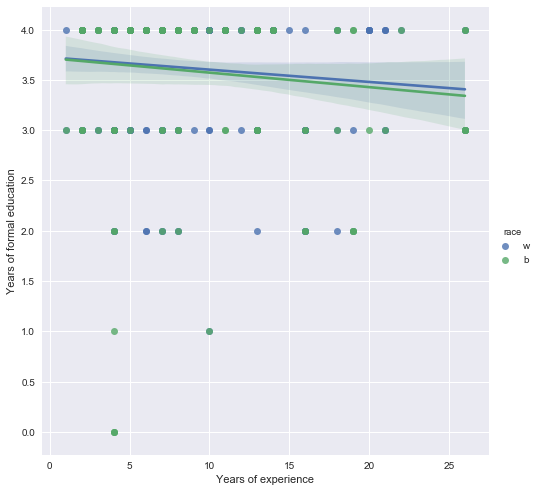

In [15]:
sns.set()

# Plot tip as a function of toal bill across days
g = sns.lmplot(x="yearsexp", y="education", hue="race",
               truncate=True, size=7, data=data_calls)

# Use more informative axis labels than are provided by default
g.set_axis_labels("Years of experience", "Years of formal education")

### Summary:

In [16]:
# Total résumés
n = data.shape[0]

# Total callbacks
n_call = data_calls.shape[0]

# Résumés white and black sounding names
total_white = data['id'].loc[(data['race'] =='w')].count()
total_black = data['id'].loc[(data['race'] =='b')].count()

# Perc.(%) white and black sounding names from total
perc_tot_white = total_white/n
perc_tot_black = total_black/n

# Perc.(%) white and black sounding names with callback
perc_call_white = call_w/n_call
perc_call_black = call_b/n_call

print("Total résumés with callback = %d" %n_call)
print("---------------------------------")
print("Perc.(%%) white-sounding names from total = %.2f%%" %(perc_tot_white*100))
print("Perc.(%%) black-sounding names from total = %.2f%%" %(perc_tot_black*100))
print("---------------------------------")
print("Perc.(%%) white-sounding names from callbacks = %.2f%%" %(perc_call_white*100))
print("Perc.(%%) black-sounding names from total = %.2f%%" %(perc_call_black*100))
print("---------------------------------")

Total résumés with callback = 392
---------------------------------
Perc.(%) white-sounding names from total = 50.00%
Perc.(%) black-sounding names from total = 50.00%
---------------------------------
Perc.(%) white-sounding names from callbacks = 59.95%
Perc.(%) black-sounding names from total = 40.05%
---------------------------------
